<a href="https://colab.research.google.com/github/MarcoMosconi/News-Article-Categorization/blob/main/News_Article_Categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install transformers
! pip install torch
! pip install scikit-learn

In [12]:
import pandas as pd
import random
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

In [2]:
data = pd.read_csv("/content/news_article_categorization.csv")
data.head()

,Text,Category
0,"Elon Musk, Amber Heard Something's Fishy On Wr...",Entertainment
1,Scientists are developing more than 100 corona...,science
2,Jared Fogle Shut Down By Judge In Bid for Earl...,Entertainment
3,The agency had come under fire from members of...,Health
4,"Credit...Jim Wilson/The New York TimesJune 30,...",Politics


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3722 entries, 0 to 3721
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      3722 non-null   object
 1   Category  3722 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB


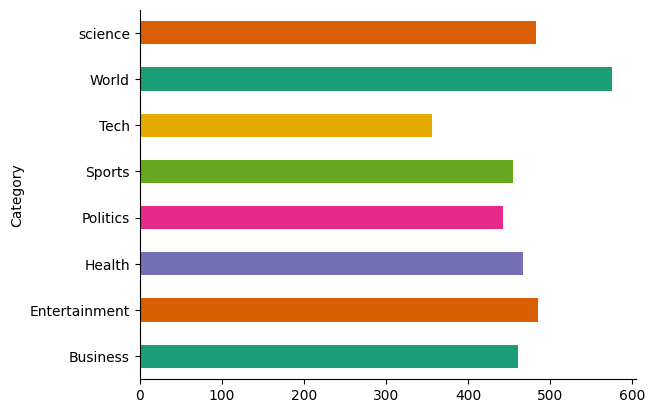

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
count = 0
for i, category in enumerate(data['Category']):
  if category in data['Text'][i:i+1][i].split(' ',1)[0].lower():
    print(category)
    count += 1
print(f'There are {count} articles starting with their category name')
count_science = data['Category'].value_counts().get('science',0)
print(f'There are {count_science} science articles')

science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
science
There are 92 articles starting with their category name
There are 482 science articles


It's not a bid deal, since just 92 out of 3722 articles start with their category's name. They are all science articles, but it's $\sim \frac15$ of the total, hence we don't think it is necessary to discard the first word ('science'). However, we'll probably obtain a better performance on the science articles  

In [6]:
seed = 42
random.seed(seed)

torch.manual_seed(seed)
if torch.cuda.is_available():
  print('true')
  torch.cuda.manual_seed_all(seed)

true


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
encoding = tokenizer.batch_encode_plus(
    data['Text'],
    padding = True,
    truncation = True,
    return_tensors = 'pt',
    add_special_tokens = True
)

In [9]:
input_ids = encoding['input_ids']
print(f'Input ID: {input_ids}')
attention_mask = encoding['attention_mask']
print(f'Attention mask: {attention_mask}')

Input ID: tensor([[ 101, 3449, 2239,  ...,    0,    0,    0],
        [ 101, 6529, 2024,  ..., 2022, 2550,  102],
        [ 101, 8334, 9666,  ...,    0,    0,    0],
        ...,
        [ 101, 4923, 1012,  ..., 7403, 3891,  102],
        [ 101, 3066, 8654,  ..., 4261, 3867,  102],
        [ 101, 2019, 1044,  ..., 2001, 3020,  102]])
Attention mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


In [10]:
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(data['Category'])
labels = torch.tensor(label)
labels

tensor([1, 7, 1,  ..., 2, 0, 2])

In [17]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, test_masks = train_test_split(attention_mask, test_size=0.2, random_state=42)

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)